# **Sentiment Analysis using Python**

### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re

import contractions
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
# from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLTK Setup
nltk.download('punkt')        # For word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')    # For stopwords
nltk.download('wordnet')      # For lemmatization

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

### **Load and Explore the Data**

In [ ]:
# data = pd.read_csv('/content/IMDB Dataset.csv', quoting=3, on_bad_lines='skip')
data=pd.read_csv('/content/IMDB Dataset.csv')
data.sample(3)

,review,sentiment
11984,1st watched 2/28/2006 - 4 out of 10(Dir-Sydney...,negative
622,These slasher pics are past their sell by date...,positive
2747,Bela Lugosi is a real enigma. In the early 193...,negative


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50803 entries, 0 to 50802
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50803 non-null  object
 1   sentiment  50803 non-null  object
dtypes: object(2)
memory usage: 793.9+ KB


In [ ]:
data.describe()

,review,sentiment
count,50803,50803
unique,49583,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25417


In [ ]:
data.drop_duplicates(inplace=True)
data.shape

(49583, 2)

In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
positive,24884
negative,24699


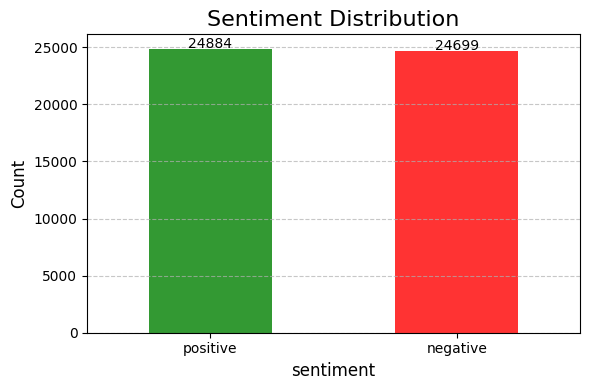

In [ ]:
# Plotting the sentiment distribution
plt.figure(figsize=(6, 4))  # Larger size for better readability
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Plot bar chart with colors
data['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'], alpha=0.8)

# Enhance x and y ticks
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Add grid for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for i, value in enumerate(data['sentiment'].value_counts()):
    plt.text(i, value + 50, str(value), ha='center', fontsize=10, color='black')

plt.tight_layout()  # To prevent clipping
plt.show()


## **Data Preprocessing**

In [ ]:
data['sentiment']=data['sentiment'].replace({'positive':1,'negative':0})
data.sample(3)

,review,sentiment
42728,"Convoluted, infuriating and implausible, Fay G...",1
27158,I read on the web that this film is being rema...,1
14167,"This was, undoubtedly, the most disturbing mov...",1


In [ ]:
def data_cleaning(x):
  x=x.lower()
  # Expand contractions
  x = contractions.fix(x)
  # Remove HTML tags
  x = re.sub(r'<.*?>', '', x)
  # Remove URLs
  x = re.sub(r'http\S+|www\S+', '', x)
  # anything thats not space and word
  re.sub(r'[^\w\s]', '', x)
  #spelling correction
  # x = str(TextBlob(x).correct())
  # Tokenization (split text into individual words)
  tokens = word_tokenize(x)
  # Stopword removal (remove common unimportant words)
  filtered_tokens = [word for word in tokens if word not in stop_words or word == "not"]
  # Lemmatization (reduce words to their base form)
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens] #filtered_tokens]
  # Join tokens back into a single string
  return " ".join(lemmatized_tokens)

In [ ]:
tqdm.pandas()

data['review']=data['review'].progress_apply(data_cleaning)

100%|██████████| 49583/49583 [03:59<00:00, 207.20it/s]


In [ ]:
data.sample(3)

,review,sentiment
39260,i have not seen all cage 's work by any mean b...,0
36958,volcano is set in los angeles where a minor ea...,0
5881,"yet again , early morning television prof an i...",1


In [ ]:
def number_of_word(x):
  return len(x.split())
data['word count']=data['review'].apply(number_of_word)
data.sample(3)

,review,sentiment,word count
30908,why wa this movie ever made ? they have tarnis...,0,141
37109,"well , dude where is my car might be at least ...",0,197
17728,before i saw this film i did not really expect...,1,292


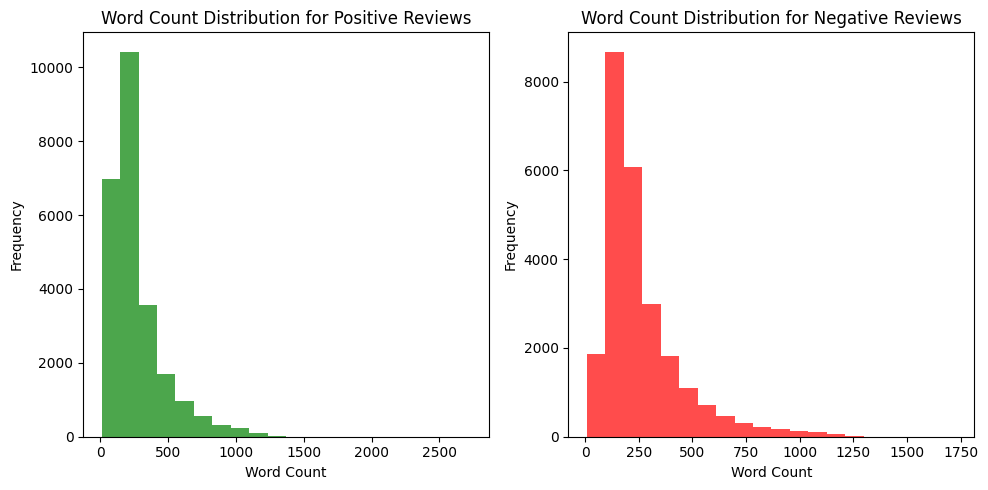

In [ ]:
positive_reviews = data[data['sentiment'] == 1]  # positive sentiment
negative_reviews = data[data['sentiment'] == 0]  # negative sentiment

# Plot for positive reviews
plt.figure(figsize=(10, 5))

# Plot for positive reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.hist(positive_reviews['word count'], bins=20, color='green', alpha=0.7)
plt.title('Word Count Distribution for Positive Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot for negative reviews
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.hist(negative_reviews['word count'], bins=20, color='red', alpha=0.7)
plt.title('Word Count Distribution for Negative Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()  # To make sure the plots don't overlap
plt.show()


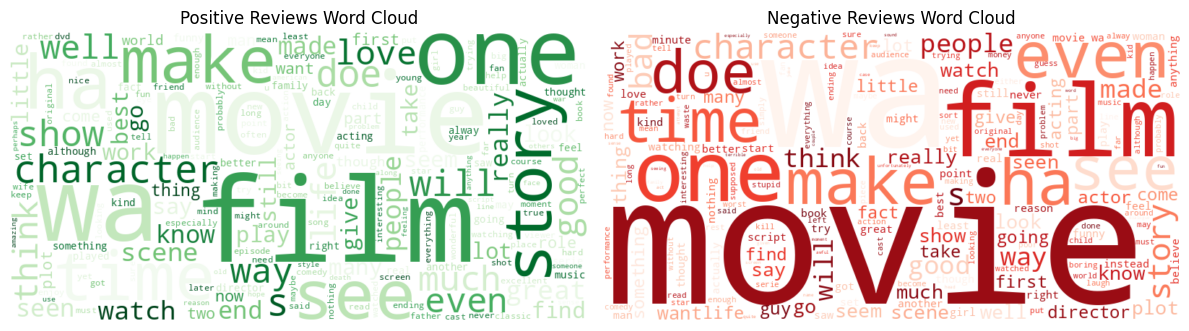

In [ ]:
#word cloud for +ve and -ve
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate data based on sentiment (assuming 0 = negative and 1 = positive)
positive_reviews = data[data['sentiment'] == 1]  # positive sentiment
negative_reviews = data[data['sentiment'] == 0]  # negative sentiment

# Combine all the text from positive reviews
positive_text = " ".join(review for review in positive_reviews['review'])

# Combine all the text from negative reviews
negative_text = " ".join(review for review in negative_reviews['review'])

# Generate Word Cloud for Positive Reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

# Generate Word Cloud for Negative Reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot Positive Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')  # Remove axes

# Plot Negative Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')  # Remove axes

plt.tight_layout()
plt.show()


## **Model Building**

In [ ]:
X=data['review']
Y=data['sentiment']

In [ ]:
tfidfv=TfidfVectorizer()
X=tfidfv.fit_transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [ ]:
print("Size of x_train: ", (X_train.shape))
print("Size of y_train: ", (Y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (Y_test.shape))

Size of x_train:  (39666, 97282)
Size of y_train:  (39666,)
Size of x_test:  (9917, 97282)
Size of y_test:  (9917,)


## **Training & Evaluation**

In [ ]:
lr=LogisticRegression()
lr.fit(X_train,Y_train)
lr_predict=lr.predict(X_test)
lr_accuracy=accuracy_score(lr_predict,Y_test)
lr_accuracy

0.8975496621962287

In [ ]:
def predict(x):
  clean_text = data_cleaning(x)
  print("Clean text: ", clean_text)
  clean_text = tfidfv.transform([clean_text])
  # print("tfidfv: ", clean_text)
  prediction_lr = lr.predict(clean_text)
  return "Positive" if prediction_lr == 1 else "Negative"

In [ ]:
x=input("enter your review: ")
prediction_lr = predict(x)
print("lr: Sentiment:", prediction_lr)


enter your review: it was a bad movie, i hated it!!!..
Clean text:  it wa a bad movie , i hated it ! ! ! ..
lr: Sentiment: Negative
